In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import datetime
import urllib.parse

VALIDATION_MEASUREMENTS = ['HYY_DMPS.tconc',  # Total particle concentration (placeholder)
                        'HYY_META.Tmm168',    # Temperature, 16.8 m
                        'HYY_META.RH168',     # Relative humidity, 16.8 m
                        'HYY_META.WDU84',     # Wind direction 8.4 m
                        'HYY_META.WSU84',     # Wind speed 8.4 m
                        'HYY_META.Precipacc'] # Precipitation

# To be added / considered later on, measurements don't seem to be available always
#'HYY_META.O384', Ozone, 8.4m
#'HYY_META.NOx84', NOx, 8.4m

def get_smear_data(start_date = datetime.datetime.now(), days_to_fetch = 3, variables_to_fetch = VALIDATION_MEASUREMENTS):
    '''This function will fetch the observational data from Hyytiälä weather station.'''

    # Check the list of stations
    url = "https://smear-backend.2.rahtiapp.fi/search/station"
    response = requests.get(url)

    #if response.status_code == 200:
        #print(f"Stations available through the API")
        #data = response.json()
        #for i in data:
            #print(i)

    # Try to fetch the temperature data from 16.8 meters above ground level for the past two days
    datetime_start = start_date
    num_days_to_fetch = datetime.timedelta(days = days_to_fetch)

    datetime_end = (datetime_start + num_days_to_fetch).isoformat()
    datetime_start = datetime_start.isoformat()

    print(f"\nFetching data from {datetime_start} to {datetime_end}.")

    dt_start = urllib.parse.quote_plus(datetime_start)
    dt_end = urllib.parse.quote_plus(datetime_end)

    # Formulate the url string
    fetch_request = "https://smear-backend.2.rahtiapp.fi/search/timeseries?aggregation=ARITHMETIC"

    # Add starting datetime
    fetch_request += "&from=" + dt_start

    # Add length of interval between data points (in minutes, 1-60)
    fetch_request += "&interval=60"
    # Add quality (ANY or CHECKED)
    fetch_request += "&quality=ANY"

    # Add request variables
    for var in variables_to_fetch:
        fetch_request += "&tablevariable=" + var

    # Finally, add the ending datetime
    fetch_request += "&to=" + dt_end

    print(f"Using the following URL:\n{fetch_request}")
    response = requests.get(fetch_request)

    if response.status_code == 200:
        # Fetch OK
        data = response.json()

        # A dictionary is returned, data will contain the measurements with time stamps
        df = pd.DataFrame.from_dict(data['data'])

        # Transform the time stamp into a default datetime format, assign it as an index
        df['datetime'] = pd.to_datetime(df['samptime'], errors = 'coerce')
        df.set_index('datetime', inplace = True)
        df.drop(columns = 'samptime', inplace = True)

        return df
    else:
        print(f"Unsuccessful")
        return pd.DataFrame()

In [2]:
import xarray as xr
from netCDF4 import Dataset
from pandas.tseries.offsets import DateOffset

# Assumption: the quantities of interest are extracted from the main simulation output file to a smaller file
chim_file = 'val_data_2025_02_12.nc'
df_sim = xr.open_dataset(chim_file, engine = 'netcdf4')

# The times of Chimere simulation are not in Helsinki time, need to adjust
times = df_sim.Times.astype(str)
utc_times = pd.to_datetime(times, format='%Y%m%d%H%M%S.%f')
local_times = utc_times + DateOffset(hours=2)
df_sim['local_times'] = pd.DatetimeIndex(local_times)

# Go through each of the variables of interest, replacing the time counters with the datetime values
df_sim = df_sim.assign_coords(hour=('local_times', local_times.hour))
ignored_vars = ['Times']
for var in df_sim.data_vars:
        df_sim[var] = df_sim[var].swap_dims({'time_counter':'local_times'})

df_sim

<xarray.Dataset> Size: 797MB
Dimensions:      (local_times: 72, bottom_top: 30, y: 189, x: 120)
Coordinates:
    nav_lat      (y, x) float32 91kB ...
    nav_lon      (y, x) float32 91kB ...
  * local_times  (local_times) datetime64[ns] 576B 2025-02-12T03:00:00 ... 20...
    hour         (local_times) int32 288B 3 4 5 6 7 8 9 10 ... 20 21 22 23 0 1 2
Dimensions without coordinates: bottom_top, y, x
Data variables:
    PM25         (local_times, bottom_top, y, x) float32 196MB ...
    Times        (local_times) float64 576B ...
    sreh         (local_times, y, x) float32 7MB ...
    temp         (local_times, bottom_top, y, x) float32 196MB ...
    topc         (local_times, y, x) float32 7MB ...
    winm         (local_times, bottom_top, y, x) float32 196MB ...
    winz         (local_times, bottom_top, y, x) float32 196MB ...
Attributes: (12/19)
    name:               ../chim_nest-FINLAND6-forecast_2025021200_72_out
    description:        Created by xios
    title:              Created by xios
    Conventions:        CF-1.6
    timeStamp:          2025-Feb-13 16:15:32 GMT
    uuid:               920638e1-81ca-438f-81a4-8acbedbae008
    ...                 ...
    Cpl_case:           1
    Physical_timestep:  20
    Chemical_timestep:  5
    Labchem:            3112100610121.10
    history:            Mon Feb 17 17:13:52 2025: ncks -C -v Times,PM25,sreh,...
    NCO:                netCDF Operators version 5.0.1 (Homepage = http://nco...

In [3]:
# Get the observations, starting from the first hour of simulation
#print(pd.to_datetime(df_sim.local_times[0].values))
#print(datetime.datetime(year=2025, month=2, day=12, hour=0))
df = get_smear_data(start_date = pd.to_datetime(df_sim.local_times[0].values))

df


Fetching data from 2025-02-12T03:00:00 to 2025-02-15T03:00:00.
Using the following URL:
https://smear-backend.2.rahtiapp.fi/search/timeseries?aggregation=ARITHMETIC&from=2025-02-12T03%3A00%3A00&interval=60&quality=ANY&tablevariable=HYY_DMPS.tconc&tablevariable=HYY_META.Tmm168&tablevariable=HYY_META.RH168&tablevariable=HYY_META.WDU84&tablevariable=HYY_META.WSU84&tablevariable=HYY_META.Precipacc&to=2025-02-15T03%3A00%3A00


,HYY_DMPS.tconc,HYY_META.RH168,HYY_META.Tmm168,HYY_META.WDU84,HYY_META.WSU84,HYY_META.Precipacc
datetime,,,,,,
2025-02-12 03:00:00,255.789009,99.980000,-3.469222,284.303940,0.709530,0.000333
2025-02-12 04:00:00,265.766416,99.980000,-3.479125,277.874793,0.843807,0.000167
2025-02-12 05:00:00,313.892471,99.980000,-3.338425,282.751282,0.740837,0.001167
2025-02-12 06:00:00,349.623815,99.980000,-3.121736,285.702762,0.773745,0.000500
2025-02-12 07:00:00,341.979914,99.980000,-2.948986,283.126358,0.631329,0.000000
...,...,...,...,...,...,...
2025-02-14 22:00:00,922.691498,97.516889,-7.218681,323.394007,0.431693,0.000000
2025-02-14 23:00:00,958.584880,98.302848,-7.486500,329.221650,0.380233,0.001000
2025-02-15 00:00:00,960.012685,98.983194,-7.445972,313.036045,0.408815,0.006343


In [4]:
# Look for the grid point where Hyytiälä station is located, for validation purposes

MAGIC_LON = 43  # Magic number to reduce number of find_nearest calls to one
MAGIC_LAT = 52  # Magic number to reduce number of find_nearest calls to one
HYYTIALA_LON = 24.2896
HYYTIALA_LAT = 61.8417

def find_nearest(array, value):
    '''Helper function to select the grid point from the simulation output containing Hyytiälä measurement station'''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Pick up the grid point corresponds to Hyytiälä
idx_lon = find_nearest(df_sim.nav_lon[MAGIC_LON, :], HYYTIALA_LON)
idx_lat = find_nearest(df_sim.nav_lat[:, MAGIC_LAT], HYYTIALA_LAT)

# Vertical layer number, corresponds to the lowest layer
VERT_LAYER_NUM = 1 


# Defien a getter function which returns the data from grid point containing the Hyytiälä station
def select_grid_point(variable):
    try:
        return variable.sel(bottom_top = VERT_LAYER_NUM).sel(x = idx_lon).sel(y = idx_lat)
    except:
        return variable.sel(x = idx_lon).sel(y = idx_lat)

ch_wind_zonal       = select_grid_point(df_sim.winz)
ch_wind_meridional  = select_grid_point(df_sim.winm)
ch_temperature      = select_grid_point(df_sim.temp) - 273.15           # Temperature, from Kelvin to celsius
ch_relhum           = select_grid_point(df_sim.sreh) * 100              # From [0...1] to [0%...100%]           
ch_precip           = select_grid_point(df_sim.topc)                    
ch_pm25             = select_grid_point(df_sim.PM25)

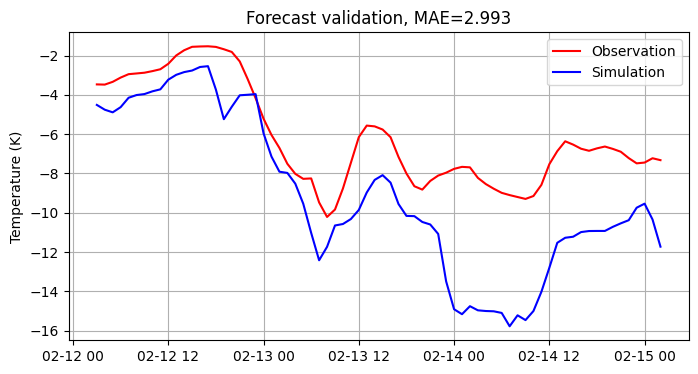

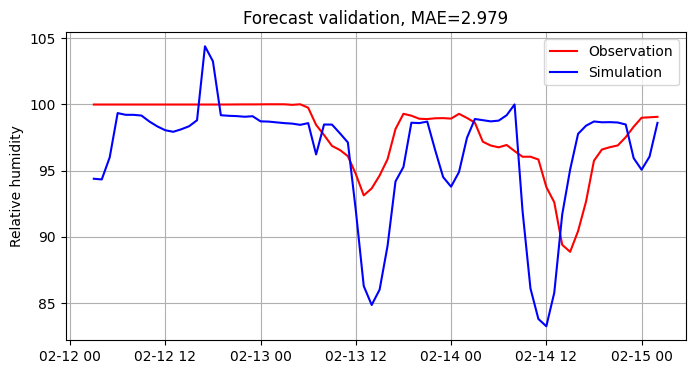

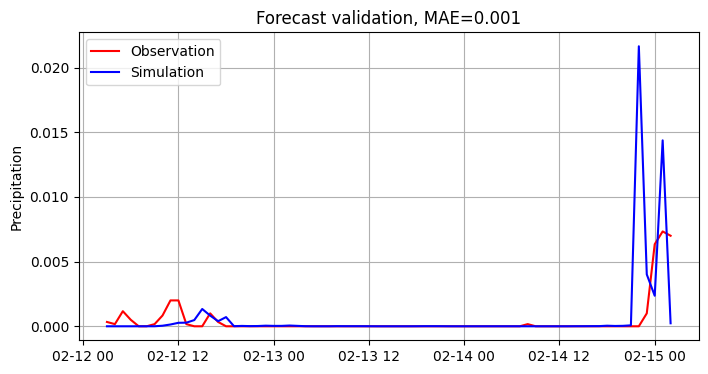

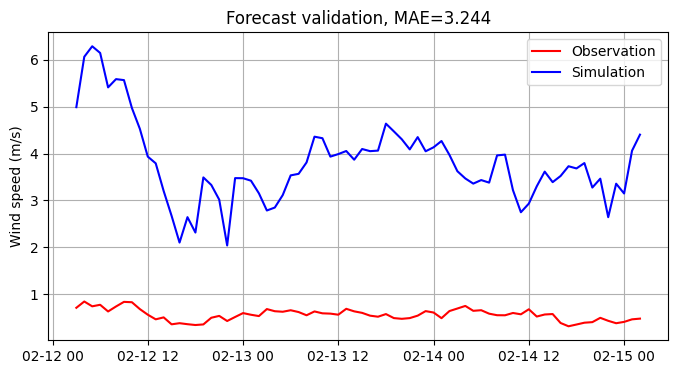

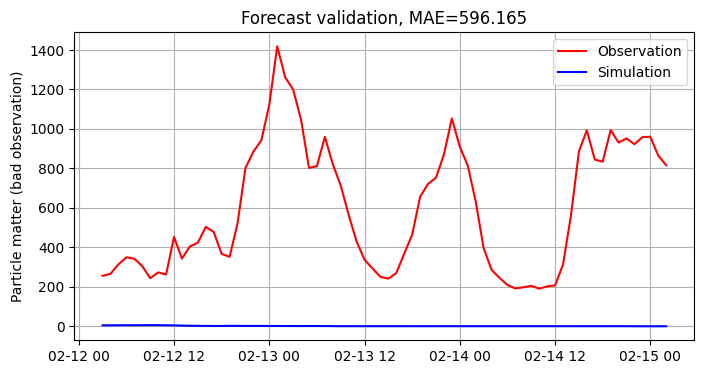

In [6]:
def compute_MAE(actual, predicted):
    '''Helper function for computed the mean absolute error (MAE) between two arrays'''
    return np.sum(np.abs(actual-predicted))/len(actual)

def plot_validation(time = np.array([x for x in range(100)]), chim = np.array([x**2.1 for x in range(100)]), obs = np.array([x**2 for x in range(100)]), label='y-axis', fig_name = 'dummy.png'):
    plt.figure(figsize = (8,4))
    plt.plot(time, obs, color='red', label='Observation')
    plt.plot(time, chim, color='blue', label='Simulation')
    plt.legend()
    plt.title(f"Forecast validation, MAE={round(compute_MAE(obs, chim),3)}")
    plt.ylabel(label)
    #fig.autofmt_xdate(rotation=45)
    plt.grid()
    plt.savefig(fig_name, dpi = 350, bbox_inches='tight')
    plt.show()

plot_validation(df_sim.local_times, ch_temperature, df['HYY_META.Tmm168'], 'Temperature (K)', 'validation_temp_2025_02_12.png')
plot_validation(df_sim.local_times, ch_relhum, df['HYY_META.RH168'], 'Relative humidity', 'validation_relhum_2025_02_12.png')
plot_validation(df_sim.local_times, ch_precip, df['HYY_META.Precipacc'], 'Precipitation', 'validation_precip_2025_02_12.png')
plot_validation(df_sim.local_times, np.sqrt(ch_wind_meridional**2 + ch_wind_zonal**2), df['HYY_META.WSU84'], 'Wind speed (m/s)', 'validation_windsp_2025_02_12.png')
plot_validation(df_sim.local_times, ch_pm25, df['HYY_DMPS.tconc'], 'Particle matter (bad observation)', 'bad_particle_matter_2025_02_12.png')
